# The Problem Description

Consider the following Gridworld example. There are 4 different actions (north, south, east, west). for all the states (cells in the grid), each one of the actions (north, south, east, and west) is chosen with probability 1⁄4. The agent then moves with probability 1 to the chosen direction. While moving, if the agent hits a wall to go off-grid or the black cells (blocked), it cannot move and it receives a reward of 0; if moving to a cell in the grid, the reward is 0.; if it reaches red
cells (fire), the game will terminate and receives a penalty -5; and, if it reaches the goal cell (G) it receives a reward +5 and the game will terminate.

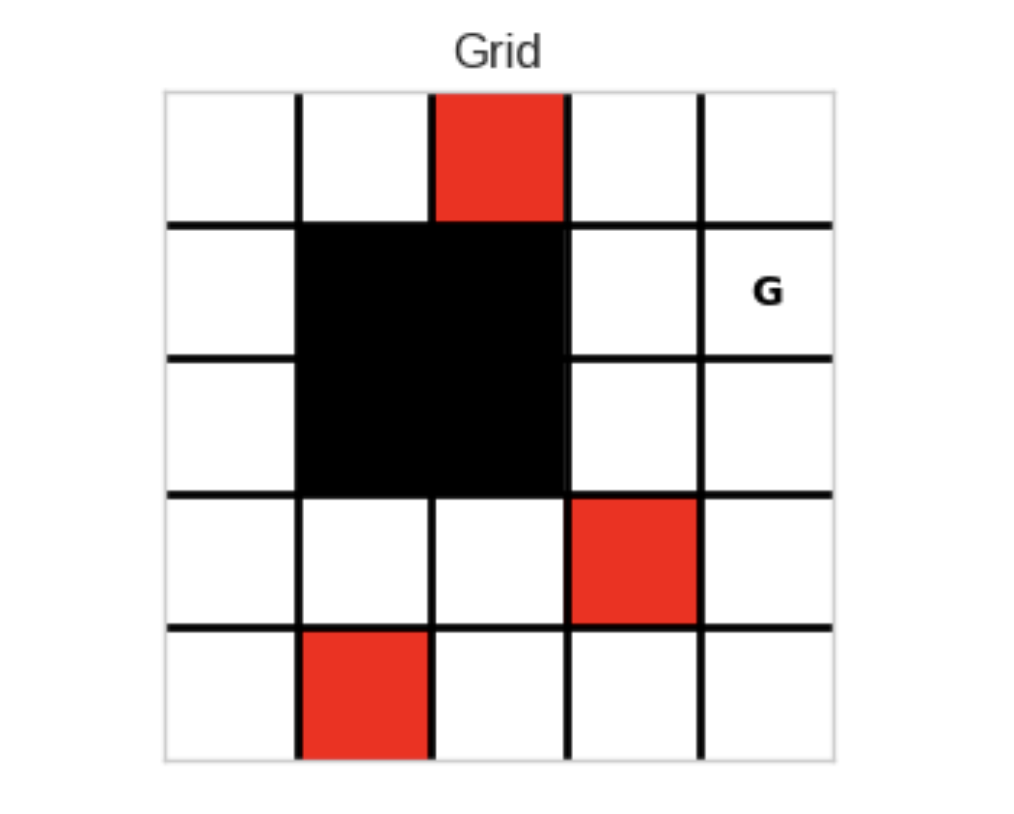

You are required to write 2 programs (in Python 3) to find the state-value for each one of the states for discount rates of 0.95 and 0.75. You are also required to find the state-value for each state when the grid is noisy (probability of resulting state not being what was expected).

In [29]:
import numpy as np
from enum import IntEnum
from copy import deepcopy
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')
import matplotlib.colors as mcolors

<ipython-input-29-b53f5efa330b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')
<ipython-input-29-b53f5efa330b>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [53]:
class GridWorld:
    def __init__(self, height, width, goal, goal_value=5.0, danger=[], danger_value=-5.0, blocked=[], noise=0.0):

        self._width = width
        self._height = height
        self._grid_values = [0 for _ in range(height * width)] # Initialize state values.
        self._goal_value = goal_value
        self._danger_value = danger_value
        self._goal_cell = {goal}
        self._danger_cells = danger
        self.blocked_cells = {(1, 1), (1, 2), (2, 1), (2, 2)}
        self.grid = np.zeros((self._height, self._width))
        self.terminal_states = {(2, 4), (0, 2), (3, 3), (4, 1)}
        self.rewards = {(2, 4): 5, (0, 2): -5, (3, 3): -5, (4, 1): -5}
        self.noise = noise
        self.actions = ['up', 'down', 'right', 'left']
        self.action_effects = {
            'up': (-1, 0),
            'down': (1, 0),
            'right': (0, 1),
            'left': (0, -1)
        }

        self.value_table = np.zeros((self._height, self._width))
        self.actions = self.actions
        self.policy = np.random.choice(len(self.actions), (self._height, self._width))
        self.create_next_values() # Initialize the next state values.

    def get_next_state(self, state, action):
        if state in self.terminal_states:
            return state
        row, col = state
        dr, dc = self.action_effects[action]
        new_row, new_col = row + dr, col + dc
        if (0 <= new_row < self._height and 0 <= new_col < self._width and
                (new_row, new_col) not in self.blocked_cells):
            return (new_row, new_col)
        return state

    def get_reward(self, state):
        return self.rewards.get(state, 0)

    def is_terminal(self, state):
        return state in self.terminal_states

    def reset(self):
        """
        Reset the state values to their initial state.
        """
        self._grid_values = [0 for _ in range(self._height * self._width)]
        self.create_next_values()

    def create_next_values(self):
        """
        Creates a temporary storage for state value updating
        If this is not used, then asynchronous updating may result in unexpected results
        To use properly, run this at the start of each iteration
        """
        self._next_values = deepcopy(self._grid_values)

    def get_transitions(self, state, action):
        transitions = []
        intended_next_state = self.get_next_state(state, action)
        transitions.append({"state": intended_next_state, "prob": 1 - self.noise})

        for other_action in self.actions:
            if other_action != action:
                next_state = self.get_next_state(state, other_action)
                transitions.append({"state": next_state, "prob": self.noise / (len(self.actions) - 1)})

        return transitions

    def solve_linear_system(self, discount_factor=1.0):
        n_states = self._height * self._width
        A = np.zeros((n_states, n_states))
        b = np.zeros(n_states)

        for row in range(self._height):
            for col in range(self._width):
                state = (row, col)
                state_index = self.state_to_index(state)

                if self.is_terminal(state) or state in self.blocked_cells:
                    A[state_index, state_index] = 1
                    b[state_index] = self.get_reward(state)
                else:
                    A[state_index, state_index] = 1
                    for action in self.actions:
                        next_state = self.get_next_state(state, action)
                        next_state_index = self.state_to_index(next_state)
                        reward = self.get_reward(next_state)
                        A[state_index, next_state_index] -= (discount_factor / len(self.actions))
                        b[state_index] += (reward / len(self.actions))

        V = np.linalg.solve(A, b)
        self.value_table = V.reshape((self._height, self._width))
        return np.round(self.value_table, 2)

    def state_to_index(self, state):
        row, col = state
        return row * self._width + col



    def __str__(self):
        out_str = ""
        for r in range(self._height):
            for c in range(self._width):
                cell = r * self._width + c
                if cell in self._blocked_cells:
                    out_str += "{:>6}".format("----")
                elif cell == self._goal_cell:
                    out_str += "{:>6}".format("GOAL")
                elif cell in self._danger_cells:
                    out_str += "{:>6.2f}".format(self._danger_value)
                else:
                    out_str += "{:>6.2f}".format(self._grid_values[cell])
                out_str += " "
            out_str += "\n"
        return out_str

In [55]:
simple_gw = GridWorld(height=5, width=5, goal=(2, 4), danger=[(0, 2), (3, 3), (4, 1)], blocked=[(1, 1), (1, 2), (2, 1), (2, 2)], noise=0.0)

# Solve the linear system
values_grid = simple_gw.solve_linear_system(discount_factor=0.95)
print(f"Grid: {values_grid} with discount factor 0.95 and noise 0.0")
values_grid = simple_gw.solve_linear_system(discount_factor=0.75)
print(f"Grid: {values_grid} with discount factor 0.75 and noise 0.0")


Grid: [[-5.25 -7.02 -5.   -3.2  -0.  ]
 [-4.59  0.    0.   -0.    3.2 ]
 [-4.89  0.    0.   -0.    5.  ]
 [-6.22 -7.62 -8.   -5.   -1.1 ]
 [-7.46 -5.   -7.78 -6.72 -3.54]] with discount factor 0.95 and noise 0.0
Grid: [[-1.37 -3.91 -5.   -2.69  0.  ]
 [-0.66  0.    0.    0.    2.69]
 [-0.84  0.    0.    0.    5.  ]
 [-2.14 -4.29 -4.78 -5.   -0.3 ]
 [-4.14 -5.   -4.74 -4.09 -1.32]] with discount factor 0.75 and noise 0.0


# Dynamic Programming

In [83]:
def value_iteration(env, discount=0.95, theta=0.1):
    value_table = np.zeros((env._height, env._width))
    actions = env.actions
    num_iterations = 0
    while True:
        delta = 0
        new_value_table = np.copy(value_table)
        for row in range(env._height):
            for col in range(env._width):
                state = (row, col)
                if env.is_terminal(state) or state in env.blocked_cells:
                    continue
                v = value_table[row, col]
                values = []
                for action in actions:
                    total_value = 0
                    transitions = env.get_transitions(state, action)
                    for transition in transitions:
                        next_state = transition["state"]
                        prob = transition["prob"]
                        reward = env.get_reward(next_state)
                        next_value = value_table[next_state[0], next_state[1]]
                        total_value += prob * (reward + (discount * next_value))
                    values.append(total_value)

                best_value = max(values)
                new_value_table[row, col] = best_value
                delta = max(delta, abs(v - new_value_table[row, col]))
        value_table = new_value_table
        num_iterations += 1
        if delta < theta:
            break

        # Update value table with pre-known values
        for row in range(env._height):
            for col in range(env._width):
                state = (row, col)
                if state in env.blocked_cells:
                    value_table[row, col] = 0
                elif state in env._danger_cells:
                    value_table[row, col] = env._danger_value

    return np.round(value_table, 2), print(f"\nAfter {num_iterations} of iterations")


In [101]:
def value_iteration(env, discount=0.95, theta=0.1):
    cumulative_rewards = []
    value_table = np.zeros((env._height, env._width))
    actions = env.actions
    num_iterations = 0
    while True:
        total_reward = 0
        delta = 0
        new_value_table = np.copy(value_table)
        for row in range(env._height):
            for col in range(env._width):
                state = (row, col)
                if env.is_terminal(state) or state in env.blocked_cells:
                    continue
                v = value_table[row, col]
                values = []
                for action in actions:
                    total_value = 0
                    transitions = env.get_transitions(state, action)
                    for transition in transitions:
                        next_state = transition["state"]
                        prob = transition["prob"]
                        reward = env.get_reward(next_state)
                        next_value = value_table[next_state[0], next_state[1]]
                        total_value += prob * (reward + (discount * next_value))
                    values.append(total_value)

                best_value = max(values)
                new_value_table[row, col] = best_value
                delta = max(delta, abs(v - new_value_table[row, col]))
                total_reward += best_value  # Accumulate reward for the episode

        cumulative_rewards.append(total_reward)
        value_table = new_value_table
        num_iterations += 1
        if delta < theta:
            break

        # Update value table with pre-known values
        for row in range(env._height):
            for col in range(env._width):
                state = (row, col)
                if state in env.blocked_cells:
                    value_table[row, col] = 0
                elif state in env._danger_cells:
                    value_table[row, col] = env._danger_value
    # for generating learning curve
    # plt.plot(range(1, num_iterations+1), cumulative_rewards)
    # plt.xlabel('Number of Iterations')
    # plt.ylabel('Cumulative Reward')
    # plt.title(f'Learning Curve when discount factor is {discount}')
    # plt.show()

    return np.round(value_table, 2), print(f"\nAfter {num_iterations} of iterations")


## Getting Value for states

In [87]:
simple_gw = GridWorld(height=5, width=5, goal=(2, 4), danger=[(0, 2), (3, 3), (4, 1)], blocked=[(1, 1), (1, 2), (2, 1), (2, 2)], noise=0.0)
noisy_gw = GridWorld(height=5, width=5, goal=(2, 4), danger=[(0, 2), (3, 3), (4, 1)], blocked=[(1, 1), (1, 2), (2, 1), (2, 2)], noise=0.2)
discount = 0.95
theta = 0.1

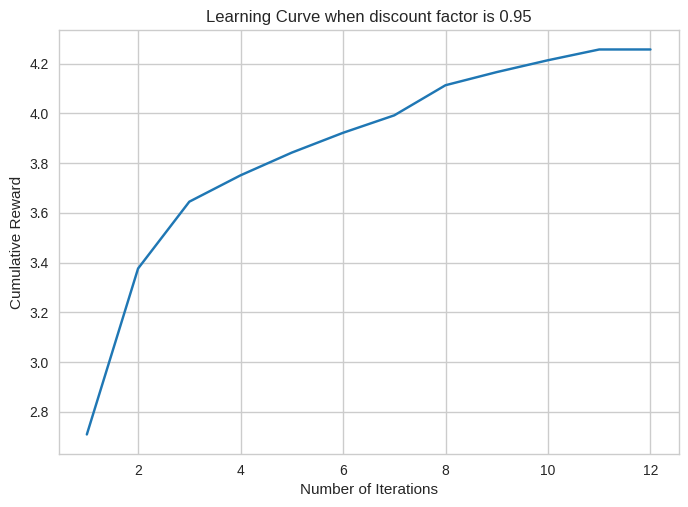


After 12 of iterations
Value iteration grid without noise and 0.95 discount factor  
 [[ 3.15  2.99 -5.    4.51  4.75]
 [ 3.32  0.    0.    4.75  5.  ]
 [ 3.49  0.    0.    5.    0.  ]
 [ 3.68  3.87  4.07 -5.    5.  ]
 [ 3.49 -5.    4.29  4.51  4.75]]


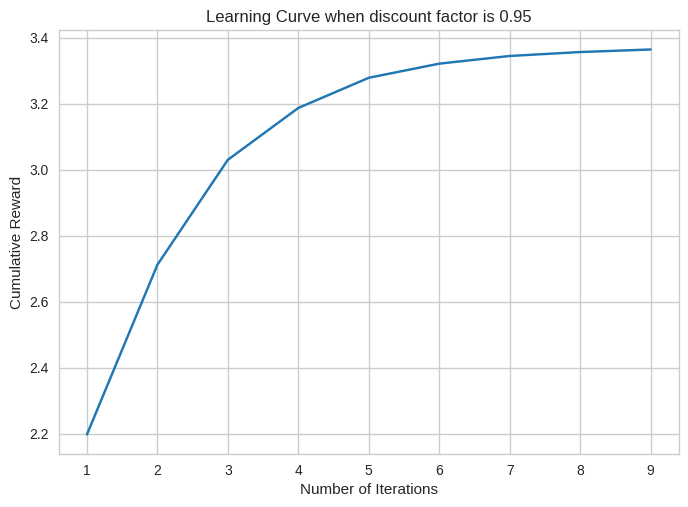


After 9 of iterations
Value iteration grid with noise and 0.95 discount factor  
 [[-0.07 -0.8  -5.    3.22  4.47]
 [-0.02  0.    0.    4.43  4.87]
 [-0.02  0.    0.    3.88  0.  ]
 [-0.13 -0.68  0.1  -5.    3.81]
 [-0.85 -5.    1.07  2.19  3.47]]


In [93]:
print("Value iteration grid without noise and 0.95 discount factor  \n", value_iteration(simple_gw, discount, 0.1)[0])

print("Value iteration grid with noise and 0.95 discount factor  \n", value_iteration(noisy_gw, discount, 0.1)[0])


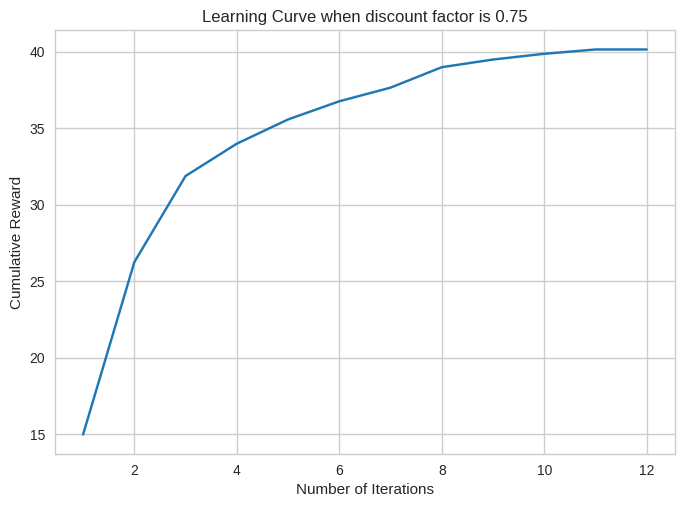


After 12 of iterations
Value iteration grid without noise and 0.75 discount factor  
 (array([[ 0.38,  0.28, -5.  ,  2.81,  3.75],
       [ 0.5 ,  0.  ,  0.  ,  3.75,  5.  ],
       [ 0.67,  0.  ,  0.  ,  5.  ,  0.  ],
       [ 0.89,  1.19,  1.58, -5.  ,  5.  ],
       [ 0.67, -5.  ,  2.11,  2.81,  3.75]]), None)


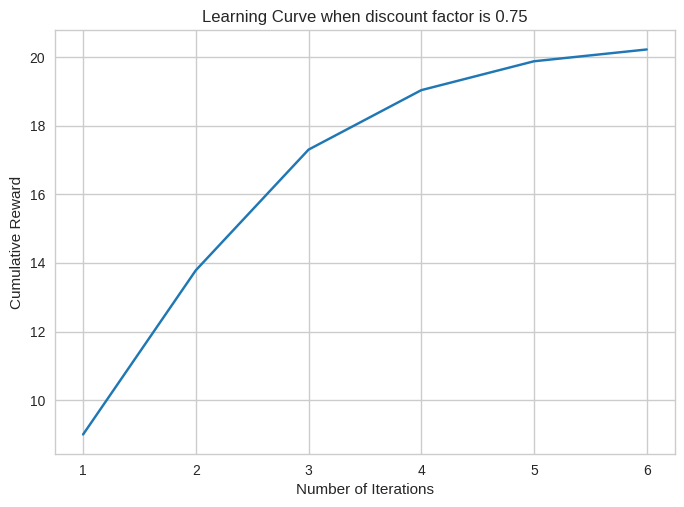


After 6 of iterations
Value iteration grid with noise and 0.75 discount factor  
 (array([[-0.04, -0.67, -5.  ,  1.51,  3.1 ],
       [-0.  ,  0.  ,  0.  ,  3.13,  4.53],
       [-0.01,  0.  ,  0.  ,  3.76,  0.  ],
       [-0.08, -0.71, -0.76, -5.  ,  3.73],
       [-0.7 , -5.  , -0.07,  0.97,  2.54]]), None)


In [91]:
print("Value iteration grid without noise and 0.75 discount factor  \n",value_iteration(simple_gw, discount=0.75, theta=0.1))

print("Value iteration grid with noise and 0.75 discount factor  \n",value_iteration(noisy_gw, discount=0.75, theta=0.1))

## Getting optimal policy

In [102]:
def get_optimal_policy(env, value_table):
    optimal_policy = np.empty((env._height, env._width), dtype=object)
    for row in range(env._height):
        for col in range(env._width):
            state = (row, col)
            if state in env._goal_cell:
                optimal_policy[row, col] = 'GOAL'
            elif state in env.blocked_cells:
                optimal_policy[row, col] = 'BLOCKED'
            elif state in env._danger_cells:
                optimal_policy[row, col] = 'DANGER'
            else:
                best_action = None
                best_value = float('-inf')
                for action in env.actions:
                    next_state = env.get_next_state(state, action)
                    next_value = value_table[next_state[0], next_state[1]]
                    if next_value > best_value:
                        best_value = next_value
                        best_action = action
                optimal_policy[row, col] = best_action
    return optimal_policy


In [105]:
print(get_optimal_policy(simple_gw, value_iteration(simple_gw, discount, 0.1)[0]))
print(get_optimal_policy(noisy_gw, value_iteration(noisy_gw, discount, 0.1)[0]))


After 12 of iterations
[['down' 'left' 'DANGER' 'down' 'down']
 ['down' 'BLOCKED' 'BLOCKED' 'down' 'right']
 ['down' 'BLOCKED' 'BLOCKED' 'left' 'GOAL']
 ['right' 'right' 'down' 'DANGER' 'right']
 ['up' 'DANGER' 'right' 'right' 'up']]

After 9 of iterations
[['down' 'left' 'DANGER' 'right' 'down']
 ['down' 'BLOCKED' 'BLOCKED' 'right' 'right']
 ['up' 'BLOCKED' 'BLOCKED' 'up' 'GOAL']
 ['up' 'right' 'down' 'DANGER' 'right']
 ['up' 'DANGER' 'right' 'right' 'up']]


In [107]:
print(get_optimal_policy(simple_gw, value_iteration(simple_gw, discount=0.75, theta=0.1)[0]))
print(get_optimal_policy(noisy_gw, value_iteration(noisy_gw, discount=0.75, theta=0.1)[0]))


After 12 of iterations
[['down' 'left' 'DANGER' 'down' 'down']
 ['down' 'BLOCKED' 'BLOCKED' 'down' 'right']
 ['down' 'BLOCKED' 'BLOCKED' 'left' 'GOAL']
 ['right' 'right' 'down' 'DANGER' 'right']
 ['up' 'DANGER' 'right' 'right' 'up']]

After 6 of iterations
[['down' 'left' 'DANGER' 'down' 'down']
 ['right' 'BLOCKED' 'BLOCKED' 'right' 'right']
 ['up' 'BLOCKED' 'BLOCKED' 'left' 'GOAL']
 ['up' 'left' 'down' 'DANGER' 'right']
 ['up' 'DANGER' 'right' 'right' 'up']]


In [108]:
# for linear results

simple_gw = GridWorld(height=5, width=5, goal=(2, 4), danger=[(0, 2), (3, 3), (4, 1)], blocked=[(1, 1), (1, 2), (2, 1), (2, 2)], noise=0.0)

# Solve the linear system
values_grid = simple_gw.solve_linear_system(discount_factor=0.95)
print(f"Grid: {values_grid} with discount factor 0.95 and noise 0.0")
print(get_optimal_policy(simple_gw, values_grid))
values_grid = simple_gw.solve_linear_system(discount_factor=0.75)
print(f"Grid: {values_grid} with discount factor 0.75 and noise 0.0")
print(get_optimal_policy(simple_gw, values_grid))



Grid: [[-5.25 -7.02 -5.   -3.2  -0.  ]
 [-4.59  0.    0.   -0.    3.2 ]
 [-4.89  0.    0.   -0.    5.  ]
 [-6.22 -7.62 -8.   -5.   -1.1 ]
 [-7.46 -5.   -7.78 -6.72 -3.54]] with discount factor 0.95 and noise 0.0
[['down' 'right' 'DANGER' 'down' 'down']
 ['right' 'BLOCKED' 'BLOCKED' 'right' 'down']
 ['up' 'BLOCKED' 'BLOCKED' 'right' 'GOAL']
 ['up' 'down' 'right' 'DANGER' 'up']
 ['right' 'DANGER' 'left' 'right' 'up']]
Grid: [[-1.37 -3.91 -5.   -2.69  0.  ]
 [-0.66  0.    0.    0.    2.69]
 [-0.84  0.    0.    0.    5.  ]
 [-2.14 -4.29 -4.78 -5.   -0.3 ]
 [-4.14 -5.   -4.74 -4.09 -1.32]] with discount factor 0.75 and noise 0.0
[['down' 'left' 'DANGER' 'down' 'down']
 ['right' 'BLOCKED' 'BLOCKED' 'right' 'down']
 ['up' 'BLOCKED' 'BLOCKED' 'right' 'GOAL']
 ['up' 'left' 'left' 'DANGER' 'up']
 ['up' 'DANGER' 'right' 'right' 'up']]
